In [1]:
import numpy as np
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%matplotlib inline

In [2]:
for i in range(2014,2020):
    df_i = pickle.load(open(f'final_{i}.pickle', "rb" ))

In [5]:
df_2014 = pickle.load(open('final_2014.pickle', "rb" ))
df_2015 = pickle.load(open('final_2015.pickle', "rb" ))
df_2016 = pickle.load(open('final_2016.pickle', "rb" ))
df_2017 = pickle.load(open('final_2017.pickle', "rb" ))
df_2018 = pickle.load(open('final_2018.pickle', "rb" ))
df_2019 = pickle.load(open('final_2019.pickle', "rb" ))

frames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019]

df = pd.concat(frames)

In [6]:
df

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,...,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
2,/cbb/boxscores/2013-11-08-air-force.html,Air Force,2013-11-08,Army,11.0,1.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,/cbb/boxscores/2013-11-08-akron.html,Akron,2013-11-08,Coastal Carolina,9.0,1.0,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,/cbb/boxscores/2013-11-08-alabama.html,Alabama,2013-11-08,Oklahoma,-9.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2593,/cbb/boxscores/2013-11-08-arizona-state.html,UMBC,2013-11-08,Arizona State,-35.0,0.0,0.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,/cbb/boxscores/2013-11-08-arizona.html,Arizona,2013-11-08,Cal Poly,11.0,1.0,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,/cbb/boxscores/2019-04-04-19-texas.html,Texas,2019-04-04,Lipscomb,15.0,1.0,0.0,0.0,36.0,0.555556,...,-0.794118,-1.235294,-2.500000,0.151746,-0.061563,0.064341,103.358824,0.066920,0.006971,-0.009602
1181,/cbb/boxscores/2019-04-05-19-depaul.html,DePaul,2019-04-05,South Florida,-12.0,0.0,1.0,0.0,35.0,0.542857,...,-1.111111,-0.194444,-1.527778,0.209364,0.049002,-0.007726,106.933333,0.003645,0.017233,-0.016221
5234,/cbb/boxscores/2019-04-06-18-virginia.html,Virginia,2019-04-06,Auburn,1.0,1.0,0.0,0.0,36.0,0.916667,...,1.184211,-5.210526,1.315789,0.056286,0.094928,0.015265,96.357895,0.028578,0.049063,0.016515
2733,/cbb/boxscores/2019-04-06-20-michigan-state.html,Michigan State,2019-04-06,Texas Tech,-10.0,0.0,0.0,0.0,38.0,0.842105,...,2.500000,-3.388889,-1.361111,0.081774,-0.353133,0.093829,103.127778,0.063058,0.015141,0.036584


In [7]:
cols = df.columns.tolist()
target = 'Spread'
all_predictors = ['Home', 'Away', 'Wins', 'Tm', 'Opp', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
                   'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%',
                   'STL%', 'BLK%', 'OeFG%', 'OTOV%', 'ORB%', 'OFT/FGA', 'DeFG%', 'DTOV%', 'DRB%', 'DFT/FGA', 'P_S', 'FG_S',
                   'FGA_S', 'FG%_S', '3P_S', '3PA_S', '3P%_S', 'FT_S', 'FTA_S', 'FT%_S', 'TRB_S', 'AST_S', 'STL_S', 'BLK_S',
                   'TOV_S', 'PF_S', 'FTr_S', '3PAr_S', 'TS%_S', 'TRB%_S', 'AST%_S', 'STL%_S', 'BLK%_S',
                   'Home_vs', 'Away_vs', 'Wins_vs', 'Tm_vs', 'Opp_vs', 'FG_vs', 'FGA_vs', 'FG%_vs', '3P_vs', '3PA_vs',
                   '3P%_vs', 'FT_vs', 'FTA_vs', 'FT%_vs', 'ORB_vs', 'TRB_vs', 'AST_vs', 'STL_vs', 'BLK_vs', 'TOV_vs',
                   'PF_vs', 'ORtg_vs', 'DRtg_vs', 'Pace_vs', 'FTr_vs', '3PAr_vs', 'TS%_vs', 'TRB%_vs', 'AST%_vs',
                   'STL%_vs', 'BLK%_vs', 'OeFG%_vs', 'OTOV%_vs', 'ORB%_vs', 'OFT/FGA_vs', 'DeFG%_vs', 'DTOV%_vs',
                   'DRB%_vs', 'DFT/FGA_vs', 'P_S_vs', 'FG_S_vs', 'FGA_S_vs', 'FG%_S_vs', '3P_S_vs', '3PA_S_vs',
                   '3P%_S_vs', 'FT_S_vs', 'FTA_S_vs', 'FT%_S_vs', 'TRB_S_vs', 'AST_S_vs', 'STL_S_vs', 'BLK_S_vs',
                   'TOV_S_vs', 'PF_S_vs', 'FTr_S_vs', '3PAr_S_vs', 'TS%_S_vs', 'TRB%_S_vs', 'AST%_S_vs', 'STL%_S_vs',
                   'BLK%_S_vs']
info_cols = ['url','Team','Date','Opponent','Win_Loss','GP','GP_vs']

In [8]:
def TVT_split(df, train_min = 12, val_min = 24, test_min = 28):
    
    df_train = df[(df.GP >= train_min) & (df.GP_vs >= train_min) & (df.GP <= (val_min -1))] 
    df_val = df[(df.GP >= val_min) & (df.GP <= (test_min -1))] 
    df_test = df[df.GP >= test_min]
    
    
    total = len(df)
    train = len(df_train)
    val = len(df_val)
    test = len(df_test)
    mature = train + val + test
    immature = total - mature
    
    
    splits = [['dataset','games','percent of total'],['total', total ,'1'],['immature', immature, immature/total],
               ['mature', mature, mature/total], ['dataset','games','percent of mature'], ['train', train, train/mature],
               ['val', val, val/mature], ['test', test, test/mature]]
 
    print(splits)
    return df_train, df_val, df_test

In [45]:
df_train_all, df_val_all, df_test_all = TVT_split(df)

[['dataset', 'games', 'percent of total'], ['total', 33200, '1'], ['immature', 13320, 0.40120481927710844], ['mature', 19880, 0.5987951807228916], ['dataset', 'games', 'percent of mature'], ['train', 12003, 0.6037726358148894], ['val', 4087, 0.20558350100603623], ['test', 3790, 0.19064386317907445]]


In [46]:
df_train = df_train_all.dropna()
df_val = df_val_all.dropna()
df_test = df_test.dropna()    

In [47]:
print([len(df_train), len(df_val), len(df_test)])

[12001, 4083, 3787]


## Keep this NaN log

In [23]:
# df_train.isnull().sum().sum()
# 6

In [30]:
def find_NAN(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    return rows_with_NaN

In [31]:
train_NaN = find_NAN(df_train)

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
train_NaN

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Team_vs,Date_vs,Opponent_vs,Spread_vs,Win_Loss_vs,Home_vs,Away_vs,GP_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
5340,/cbb/boxscores/2014-01-30-elon.html,Western Carolina,2014-01-30,Elon,-14.0,0.0,0.0,1.0,19.0,0.473684,71.157895,72.789474,24.736842,59.684211,0.415684,7.578947,20.684211,0.369789,14.105263,20.421053,NaN,11.105263,30.684211,11.894737,7.684211,4.00,12.736842,22.842105,100.663158,102.884211,70.615789,0.345947,0.347632,0.513368,49.000,47.70,10.884211,11.821053,0.479632,15.447368,32.352632,0.238526,0.509474,17.915789,69.236842,0.423632,-1.631579,1.578947,8.842105,-0.041211,2.263158,4.736842,0.029053,-7.052632,-9.052632,NaN,-1.368421,-0.105263,1.421053,1.105263,-1.421053,4.947368,-0.077701,0.157609,-0.056584,97.00,-0.000296,0.020217,0.015778,Elon,2014-01-30,Western Carolina,14.0,1.0,1.0,0.0,18.0,0.444444,71.444444,74.50,24.722222,55.388889,0.447889,8.111111,21.666667,0.367278,13.888889,19.388889,0.712667,6.888889,29.388889,13.444444,4.722222,2.722222,12.333333,19.388889,102.138889,106.40,69.222222,0.360278,0.390722,0.55300,48.044444,54.100,6.644444,6.916667,0.521056,16.044444,23.566667,0.258222,0.511556,14.261111,71.688889,0.32100,-3.055556,-1.166667,-0.722222,-0.015667,2.666667,6.277778,0.009833,-3.388889,-5.388889,NaN,-3.00,2.00,-2.055556,0.277778,1.055556,0.277778,0.039241,0.292688,-0.004308,95.088889,0.028460,-0.030596,0.004376
5044,/cbb/boxscores/2018-01-27-16-vanderbilt.html,Vanderbilt,2018-01-27,TCU,3.0,1.0,1.0,0.0,20.0,0.350000,70.850000,71.500000,23.300000,55.300000,0.421350,8.050000,25.300000,0.314100,16.200000,22.250000,0.731,8.650000,32.050000,12.250000,4.800000,3.65,11.000000,20.650000,104.420000,105.500000,67.760000,0.410200,0.456350,0.537250,51.075,51.77,7.060000,9.475000,0.493850,14.150000,27.125000,0.298250,0.493350,12.450000,74.950000,0.305850,-0.650000,-1.350000,-0.650000,-0.021050,2.300000,7.850000,-0.017150,-0.250000,-0.150000,NaN,1.100000,1.350000,0.250000,-0.300000,1.450000,1.550000,0.104374,0.389800,-0.007197,101.15,0.017457,0.004361,-0.004344,TCU,2018-01-27,Vanderbilt,-3.0,0.0,0.0,1.0,20.0,0.750000,87.250000,77.35,31.200000,62.400000,0.504050,9.200000,22.650000,0.402200,15.650000,21.800000,NaN,9.800000,34.400000,20.000000,6.900000,3.650000,12.100000,16.750000,116.305000,102.97,73.405000,0.360850,0.366150,0.60375,55.225000,64.255,9.120000,9.700000,0.578900,14.295000,31.635000,0.258600,0.531750,15.840000,76.815000,0.22665,9.900000,3.450000,1.550000,0.043850,0.550000,-1.100000,0.042350,2.450000,3.000000,NaN,6.25,3.55,1.250000,-0.400000,-1.000000,-2.550000,0.134266,-0.128814,0.041120,109.450000,0.048599,0.016870,-0.006255


In [24]:
# df_val.isnull().sum().sum()
# 12

In [38]:
val_NaN = find_NAN(df_val)

In [39]:
val_NaN

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Team_vs,Date_vs,Opponent_vs,Spread_vs,Win_Loss_vs,Home_vs,Away_vs,GP_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
3847,/cbb/boxscores/2015-02-14-robert-morris.html,Robert Morris,2015-02-14,Central Connecticut,1.0,1.0,1.0,0.0,25.0,0.480000,67.480000,68.800000,23.520000,53.800000,0.440960,5.760000,16.240000,0.370560,14.680000,20.680000,0.703760,8.760000,30.200000,12.000000,8.360000,3.040000,13.920000,19.400000,98.508000,99.940000,68.520000,0.402960,0.300600,0.533240,48.000000,50.524000,12.144000,8.448000,0.494880,17.932000,28.292000,0.286440,0.487880,17.312000,65.768000,0.268080,-1.320000,-0.320000,-1.600000,0.011240,-0.640000,-3.520000,0.046520,-0.040000,-1.800000,NaN,-2.760000,-2.920000,1.880000,-0.800000,0.120000,1.000000,0.134806,-0.142129,0.006013,95.000000,-0.041609,0.028380,-0.013328,Central Connecticut,2015-02-14,Robert Morris,-1.0,0.0,0.0,1.0,26.0,0.115385,58.384615,71.038462,21.076923,53.423077,0.397808,4.423077,14.153846,0.300038,11.807692,16.423077,NaN,9.076923,29.653846,10.461538,4.692308,3.461538,13.615385,14.076923,89.030769,107.903846,65.715385,0.313808,0.269231,0.479115,47.884615,49.365385,7.130769,9.180769,0.439846,18.300000,28.457692,0.223962,0.523846,13.423077,68.311538,0.174731,-12.653846,-5.884615,-5.076923,-0.065231,-2.692308,-6.153846,-0.050077,1.807692,2.076923,NaN,-2.730769,-3.769231,-1.653846,-0.230769,3.500000,-1.769231,0.139117,-0.079293,-0.070748,94.769231,-0.056139,-0.025746,-0.002773
3752,/cbb/boxscores/2016-02-13-ipfw.html,Purdue-Fort Wayne,2016-02-13,Denver,4.0,1.0,1.0,0.0,24.0,0.708333,76.833333,75.458333,26.625000,58.958333,0.449250,10.166667,25.041667,0.404083,13.416667,19.375000,0.706042,7.833333,32.750000,14.750000,4.958333,3.541667,12.125000,17.916667,105.725000,103.904167,71.645833,0.343792,0.429125,0.562792,50.295833,55.491667,6.816667,8.716667,0.535208,15.179167,24.262500,0.238208,0.514333,13.195833,75.604167,0.223458,1.375000,-0.791667,-1.666667,-0.003125,2.750000,4.791667,0.040917,0.208333,-0.125000,NaN,0.083333,2.833333,-0.708333,0.541667,1.500000,-1.458333,0.120243,0.228473,0.017861,99.591667,0.039507,-0.010124,0.007543,Denver,2016-02-13,Purdue-Fort Wayne,-4.0,0.0,0.0,1.0,25.0,0.520000,64.080000,64.800000,21.720000,46.280000,0.472680,7.240000,20.040000,0.354560,13.400000,17.600000,NaN,4.440000,23.320000,14.240000,6.200000,2.400000,12.120000,19.040000,101.624000,103.328000,62.820000,0.392680,0.430440,0.587480,43.304000,64.664000,9.932000,7.456000,0.550200,18.248000,16.624000,0.297680,0.520880,19.348000,69.012000,0.328080,-0.720000,0.160000,-1.680000,0.018000,1.000000,3.200000,-0.017920,-2.040000,-3.160000,NaN,-6.680000,2.440000,0.400000,-0.120000,-1.720000,0.840000,0.064556,0.108504,0.015858,85.608000,0.037006,0.006798,-0.002020
4916,/cbb/boxscores/2017-03-04-cal-poly.html,UCSB,2017-03-04,Cal Poly,13.0,1.0,0.0,1.0,26.0,0.153846,60.346154,72.769231,22.000000,58.807692,0.377692,5.461538,19.153846,0.292038,10.884615,17.153846,0.631808,11.076923,32.961538,11.923077,5.307692,2.115385,12.269231,18.423077,88.592308,106.419231,67.834615,0.303423,0.322231,0.453923,49.288462,54.150000,7.742308,6.750000,0.424462,15.542308,29.665385,0.192346,0.531615,14.850000,72.200000,0.238077,-12.423077,-3.538462,2.6538

In [25]:
# df_test.isnull().sum().sum()
# 74

In [40]:
test_NaN = find_NAN(df_test)

In [41]:
test_NaN

,url,Team,Date,Opponent,Spread,Win_Loss,Home,Away,GP,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Team_vs,Date_vs,Opponent_vs,Spread_vs,Win_Loss_vs,Home_vs,Away_vs,GP_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
1019,/cbb/boxscores/2015-03-09-delaware-state.html,Delaware State,2015-03-09,Savannah State,6.0,1.0,0.0,0.0,29.0,0.448276,69.965517,73.827586,24.448276,59.448276,0.413138,7.862069,22.517241,0.344724,13.206897,18.310345,0.706379,10.137931,34.827586,12.137931,4.965517,3.896552,13.724138,18.068966,98.120690,102.606897,71.196552,0.313586,0.378793,0.514517,50.306897,49.534483,7.024138,10.368966,0.479103,16.868966,29.689655,0.227103,0.484828,13.479310,70.558621,0.269379,-3.862069,-0.965517,-0.482759,-0.011207,0.482759,0.724138,0.013586,-2.413793,-4.379310,NaN,0.724138,-2.241379,-2.275862,0.103448,2.758621,0.310345,0.044158,0.036761,-0.012455,99.613793,-0.027722,-0.030347,0.002565,Savannah State,2015-03-09,Delaware State,-6.0,0.0,0.0,0.0,28.0,0.250000,55.642857,67.750000,21.000000,51.428571,0.412393,3.250000,12.785714,0.263464,10.392857,18.392857,NaN,8.25000,25.714286,9.071429,8.821429,2.428571,16.071429,19.607143,82.246429,100.028571,67.339286,0.367321,0.248643,0.463929,45.332143,43.064286,13.060714,6.971429,0.444893,21.032143,26.725000,0.210357,0.527750,21.675000,67.414286,0.375071,-12.107143,-1.75000,3.464286,-0.062214,-1.892857,-1.071429,-0.095679,-6.714286,-5.928571,NaN,-5.571429,-3.071429,-0.642857,-3.035714,-0.285714,1.035714,-0.007735,0.042109,-0.114703,89.664286,-0.044662,-0.008858,-0.045441
1824,/cbb/boxscores/2017-03-04-illinois-state.html,Illinois State,2017-03-04,Southern Illinois,13.0,1.0,0.0,0.0,30.0,0.833333,69.200000,60.800000,24.600000,55.233333,0.448367,8.300000,22.666667,0.364800,11.700000,17.633333,NaN,8.800000,33.800000,13.666667,7.200000,4.666667,12.433333,17.633333,102.696667,89.870000,67.193333,0.328433,0.413067,0.546800,52.956667,55.896667,10.633333,13.590000,0.524200,16.396667,28.406667,0.219067,0.438633,16.263333,75.146667,0.228400,8.400000,3.833333,0.166667,0.071367,1.500000,1.133333,0.055600,-0.766667,-0.333333,NaN,3.666667,2.333333,1.300000,2.266667,0.066667,0.833333,0.100031,-0.142345,0.064599,104.913333,0.035486,0.019328,0.033181,Southern Illinois,2017-03-04,Illinois State,-13.0,0.0,0.0,0.0,31.0,0.516129,68.548387,69.741935,24.516129,56.580645,0.435935,5.387097,16.967742,0.325645,14.129032,20.387097,0.684355,8.83871,30.612903,11.548387,6.903226,3.806452,11.451613,18.193548,99.896774,101.532258,67.454839,0.365129,0.299290,0.517097,48.890323,46.596774,10.129032,11.267742,0.483839,14.722581,27.548387,0.252355,0.525161,17.551613,71.229032,0.233387,-1.193548,-0.16129,2.129032,-0.018032,-2.387097,-2.870968,-0.070097,1.516129,1.354839,NaN,-1.387097,-1.032258,1.709677,0.354839,-1.967742,-0.322581,0.131832,-0.123723,-0.037934,96.780645,-0.013966,0.025680,0.004762
5110,/cbb/boxscores/2018-04-02-21-villanova.html,Villanova,2018-04-02,Michigan,17.0,1.0,0.0,0.0,39.0,0.897436,86.769231,70.384615,30.589744,61.102564,0.501487,11.641026,29.000000,0.397923,13.948718,17.897436,0.774256,8.333333,33.230769,16.615385,6.512821,4.076923,10.000000,16.076923,120.576923,97.643590,71.338462,0.302308,0.471897,0.625769,53.397436,53.882051,9.084615,10.461538,0.596359,12.520513,27.446154,0.236462,0.486462,15.594872,76.992308,0.2005

In [ ]:
#Note: Needed to drop NANS... due to timing. however, this only removes 2 games from train, 4 from validate, and 3 from test.
##unfortunately the one removed from test is the 2018 championship game =()

In [48]:
sc = StandardScaler()

In [49]:
def preprocess(df_train, df_val, df_test):
    '''
    pre-process the data...
    '''
    # get predictor columns
    X_train = df_train[all_predictors]
    X_val = df_val[all_predictors]
    X_test = df_test[all_predictors]
    
    #scale all predictors using training data
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    X_test = sc.transform(X_test)
    
    #add constants
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)
    X_test = sm.add_constant(X_test)
    
    #convert back to data frame
    X_train = pd.DataFrame(X_train, columns = ['const']+all_predictors,index = df_train.index)
    X_val = pd.DataFrame(X_val, columns = ['const']+all_predictors, index = df_val.index)
    X_test = pd.DataFrame(X_test, columns = ['const']+all_predictors, index = df_test.index)
        
        
    #get targets
    y_train = pd.DataFrame(df_train['Spread'])
    y_val = pd.DataFrame(df_val['Spread'])
    y_test = pd.DataFrame(df_test['Spread'])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [50]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess(df_train, df_val, df_test)

In [51]:
X_train

,const,Home,Away,Wins,Tm,Opp,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,ORtg,DRtg,Pace,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,P_S,FG_S,FGA_S,FG%_S,3P_S,3PA_S,3P%_S,FT_S,FTA_S,FT%_S,TRB_S,AST_S,STL_S,BLK_S,TOV_S,PF_S,FTr_S,3PAr_S,TS%_S,TRB%_S,AST%_S,STL%_S,BLK%_S,Home_vs,Away_vs,Wins_vs,Tm_vs,Opp_vs,FG_vs,FGA_vs,FG%_vs,3P_vs,3PA_vs,3P%_vs,FT_vs,FTA_vs,FT%_vs,ORB_vs,TRB_vs,AST_vs,STL_vs,BLK_vs,TOV_vs,PF_vs,ORtg_vs,DRtg_vs,Pace_vs,FTr_vs,3PAr_vs,TS%_vs,TRB%_vs,AST%_vs,STL%_vs,BLK%_vs,OeFG%_vs,OTOV%_vs,ORB%_vs,OFT/FGA_vs,DeFG%_vs,DTOV%_vs,DRB%_vs,DFT/FGA_vs,P_S_vs,FG_S_vs,FGA_S_vs,FG%_S_vs,3P_S_vs,3PA_S_vs,3P%_S_vs,FT_S_vs,FTA_S_vs,FT%_S_vs,TRB_S_vs,AST_S_vs,STL_S_vs,BLK_S_vs,TOV_S_vs,PF_S_vs,FTr_S_vs,3PAr_S_vs,TS%_S_vs,TRB%_S_vs,AST%_S_vs,STL%_S_vs,BLK%_S_vs
3341,1.0,0.987167,-0.982898,-1.575277,-0.331754,1.013791,-0.589299,0.248335,-0.963573,0.683280,0.769639,0.085920,-0.143344,-0.521836,1.259331,-0.326850,-1.143016,0.044365,0.688097,-1.515114,-0.750065,0.896859,-0.358022,1.423925,-0.065569,-0.628791,0.754456,-0.483667,-1.704861,0.541094,0.676249,-1.507365,-0.576451,-0.662877,-0.716324,-0.304842,1.226451,0.191346,-1.501052,1.176623,-1.030850,-0.944171,0.611808,-1.329422,0.237069,0.529282,-0.453152,-0.956881,-1.165645,0.457861,-1.674730,-0.940361,0.425772,-1.424718,-0.784346,1.301248,-1.314533,0.917266,-1.145224,-1.704861,-0.945654,0.338420,-1.425601,-0.982898,0.987167,-0.394931,0.241421,0.912657,-0.022861,0.083319,0.033287,0.776808,-0.048432,2.046392,0.201406,0.506798,-1.021961,0.342959,-0.634597,0.295512,-0.569993,-1.459367,-0.683735,1.972203,0.495557,1.376680,-0.031730,0.461980,-0.095120,0.249231,-0.630692,0.546723,-0.554727,-1.438138,0.335202,-0.627296,0.264085,0.176320,0.447720,-0.326651,-1.816870,2.965833,-0.513352,0.105376,1.096899,-0.349911,1.041519,0.096169,2.082071,-2.083078,-1.990389,-1.256740,-0.734452,0.001090,0.046893,-1.881156,-0.344606,1.669661,-1.674003,0.177004,-0.488449,-0.630692,0.023443,0.055410,-1.838734
3480,1.0,0.987167,-0.982898,0.388108,-0.604936,-1.237993,-1.146876,-1.215571,-0.491222,0.025794,0.316851,-0.626840,0.651534,0.458752,0.617466,-0.964019,-0.060280,0.044365,-1.708291,-0.243872,-1.121572,0.271579,-0.056891,-0.866542,-0.957596,0.942646,0.984958,0.000103,-0.197396,1.296548,-1.539856,-0.536109,-0.204828,-0.627717,-0.846289,1.144594,-1.317452,-1.025141,0.335103,0.458697,0.463896,0.046227,-0.377768,0.259636,1.342043,1.563150,0.112290,0.362641,-0.302883,1.462538,-0.129054,0.552764,-1.008111,-0.970914,0.233185,-0.447008,0.462353,1.366271,0.781706,-0.197396,0.561843,-1.019149,-1.146767,-0.982898,0.987167,0.385904,0.611423,0.163255,0.422337,0.286780,0.334737,-0.787657,-1.165275,0.766210,1.300836,1.327766,0.115534,1.800453,0.298814,-0.373287,0.495996,1.176379,0.660029,0.772461,0.502482,0.084743,0.378420,1.149808,-1.340097,0.182070,0.800280,-0.900418,0.290434,0.980166,-0.036713,0.196190,2.019208,1.194048,0.040071,0.450778,-0.592925,1.072216,0.360954,0.295598,0.639652,-0.160362,0.424165,-0.063750,1.072402,0.125155,0.217652,-0.040878,0.835155,0.336032,0.261526,0.000871,-0.069848,-0.327819,0.200223,-0.165981,-0.053575,0.800280,0.276020,0.185294,-0.014242
152,1.0,0.987167,-0.982898,1.566140,1.294331,-1.184058,1.466767,0.271572,1.703823,1.340766,0.588524,1.711905,-0.316144,-0.160567,-0.757957,-0.326850,1.355604,1.824814,-0.909495,3.075481,-1.705368,-0.895610,1.807802,-1.303364,-0.092379,-0.325718,0.606992,1.687034,0.496893,1.448516,-0.960032,2.254888,1.940238,-1.612209,-0.328187,-0.406176,-2.112869,-1.397535,0.204928,-1.027168,1.917691,1.696889,-0.788080,2.128015,2.398975,1.259071,2.785126,0.362641,0.118465,0.248486,0.551779,2.158578,0.213345,2.375890,-0.275580,-0.781781,0.428637,0.265056,2.476766,0.496893,2.185833,0.219933,2.383323,-0.982898,0.987167,-0.004514,0.483836,-0.047103,0.901780,0.060712,1.398032,-0.679763,-1.254622,0.734205,-0.073452,0.942937,-1.864696,0.342959,1.369492,1.475747,-0.636617,2.886052,0.176274,0.482868,0.567111,-0.267830,0.135

In [52]:
y_train

,Spread
3341,6.0
3480,-1.0
152,13.0
459,-4.0
2076,7.0
...,...
4663,-2.0
3842,-8.0
5580,-8.0
1888,-9.0


## Initial Model - OLS using all stats

In [53]:
# Create your model
model = sm.OLS(y_train,X_train)

# Fit your model to your training set
fit1 = model.fit()
ypred = fit1.predict(X_train)


In [54]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Spread   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     50.66
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:49:17   Log-Likelihood:                -45738.
No. Observations:               12001   AIC:                         9.171e+04
Df Residuals:                   11882   BIC:                         9.259e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0722      0.100      0.719      0.472      -0.125       0.269
Home        -1.56e+12   4.84e+12     -0.322      0.747    -1.1e+13    7.92e+12
Away       -1.584e+12   4.91e+12     -0.322      0.747   -1.12e+13    8.05e+12
Wins           0.7121      0.295      2.418      0.016       0.135       1.289
Tm         -6.963e+09   2.16e+10     -0.322      0.747   -4.93e+10    3.54e+10
Opp         6.718e+09   2.08e+10      0.322      0.747   -3.41e+10    4.76e+10
FG           -86.6343     90.668     -0.956      0.339    -264.359      91.090
FGA            0.6808      2.772      0.246      0.806      -4.753       6.115
FG%           -0.5072      8.016     -0.063      0.950     -16.219      15.205
3P           -29.1763     28.875     -1.010      0.312     -85.775      27.423
3PA            3.2916      2.977      1.106      0.269      -2.543       9.126
3P%            0.5579      0.589      0.947      0.344      -0.597       1.713
FT           -37.1556     45.983     -0.808      0.419    -127.290      52.979
FTA           -5.3079      3.464     -1.532      0.125     -12.098       1.482
FT%           -0.0263      0.469     -0.056      0.955      -0.946       0.893
ORB           -1.4966      1.100     -1.361      0.174      -3.653       0.659
TRB            0.2463      0.896      0.275      0.783      -1.509       2.002
AST           -0.2874      1.170     -0.246      0.806      -2.581       2.006
STL            1.0902      3.082      0.354      0.724      -4.950       7.130
BLK           -0.6869      0.981     -0.701      0.484      -2.609       1.235
TOV           -3.1411      2.441     -1.287      0.198      -7.926       1.644
PF             1.6417      0.397      4.139      0.000       0.864       2.419
ORtg           0.3226      3.020      0.107      0.915      -5.597       6.243
DRtg           1.3410      2.914      0.460      0.645      -4.370       7.052
Pace          -0.1097      0.539     -0.204      0.839      -1.166       0.947
FTr           57.7895     94.992      0.608      0.543    -128.410     243.989
3PAr          -1.7866      2.726     -0.655      0.512      -7.131       3.558
TS%           -2.5789      4.830     -0.534      0.593     -12.047       6.889
TRB%        2.349e+08   7.29e+08      0.322      0.747   -1.19e+09    1.66e+09
AST%           0.1238      0.797      0.155      0.877      -1.439       1.686
STL%          -0.0412      2.963     -0.014      0.989      -5.849       5.766
BLK%           1.0838      0.912      1.188      0.235      -0.704       2.871
OeFG%          4.7239      7.523      0.628      0.530     -10.023      19.470
OTOV%          2.2805      1.917      1.190      0.234      -1.477       6.038
ORB%           1.8580      1.254      1.481      0.139      -0.601       4.317
OFT/FGA       -2.6734      3.424     -0.781      0.435      -9.385       4.038
De

In [97]:
prediction = pd.concat([y_train, ypred, abs(y_train.Spread-ypred)],axis=1)
prediction.columns = ["Actual","Estimate","Absolute Error"]

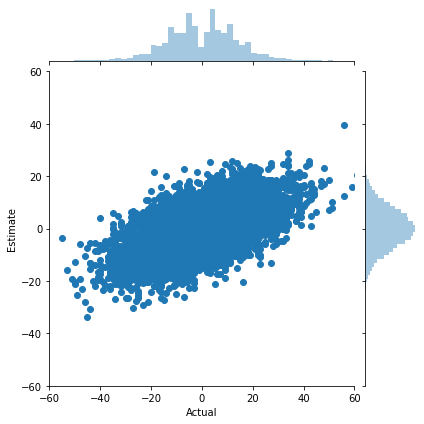

In [93]:
sns.jointplot(x= prediction.Actual, y = prediction.Estimate, xlim = [-60,60], ylim = [-60,60]);

In [96]:
prediction.describe()

,Actual,Estimate,Error
count,12001.000000,12001.000000,12001.000000
mean,0.072161,0.072263,8.624529
std,13.410945,7.773187,6.727722
min,-55.000000,-33.693258,0.002114
25%,-9.000000,-5.091186,3.417994
50%,1.000000,0.101864,7.134162
75%,9.000000,5.329290,12.333223
max,61.000000,39.535701,51.434253


In [90]:
sns.histogram()

0.07216065327889343

In [57]:
valpred = fit1.predict(X_val)

In [100]:
val_prediction = pd.concat([y_val, valpred, abs(y_val.Spread-valpred)],axis=1)
val_prediction.columns = ["Actual","Estimate","Absolute Error"]
val_prediction.describe()

,Actual,Estimate,Absolute Error
count,4083.000000,4083.000000,4083.000000
mean,-0.096988,0.147044,8.657305
std,13.597180,7.614318,6.713068
min,-58.000000,-26.367664,0.006149
25%,-9.000000,-4.900671,3.404260
50%,-1.000000,0.206097,7.217844
75%,9.000000,5.149658,12.342035
max,58.000000,28.077294,42.825498


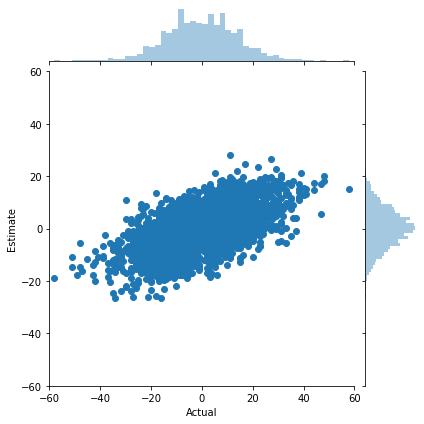

In [94]:
sns.jointplot(x= val_prediction.Actual, y = val_prediction.Estimate, xlim = [-60,60], ylim = [-60,60]);

In [101]:
testpred = fit1.predict(X_test)
test_prediction = pd.concat([y_test, testpred, abs(y_test.Spread-testpred)],axis=1)
test_prediction.columns = ["Actual","Estimate","Absolute Error"]
test_prediction.describe()

,Actual,Estimate,Absolute Error
count,3787.000000,3787.000000,3787.000000
mean,0.513599,1.251493,8.780423
std,13.136812,6.619359,6.919930
min,-45.000000,-25.384127,0.009294
25%,-8.000000,-3.124508,3.404487
50%,1.000000,1.284942,7.185168
75%,9.000000,5.584058,12.526077
max,61.000000,32.636944,41.096919


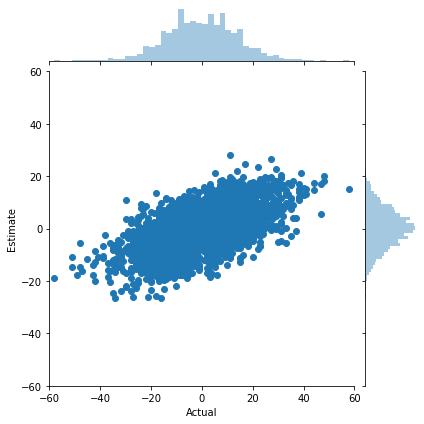

In [95]:
sns.jointplot(x= val_prediction.Actual, y = val_prediction.Estimate, xlim = [-60,60], ylim = [-60,60]);

## Lasso Regression

In [67]:
fit_lasso = model.fit_regularized(alpha = 0.06,L1_wt = 0,start_params=fit1.params)

In [68]:
final = sm.regression.linear_model.OLSResults(model,fit_lasso.params,model.normalized_cov_params)

In [69]:
print(final.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     49.48
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:54:48   Log-Likelihood:                -45785.
No. Observations:               12001   AIC:                         9.181e+04
Df Residuals:                   11882   BIC:                         9.269e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0681      0.101      0.676      0.4

In [73]:
params = list(zip(final.params,['const']+all_predictors))

In [74]:
params

[(0.06807608799895447, 'const'),
 (0.7253056000593593, 'Home'),
 (-0.8677601609826393, 'Away'),
 (0.6194997579150294, 'Wins'),
 (0.18689702119551668, 'Tm'),
 (-0.2837314591047423, 'Opp'),
 (0.1841504658823511, 'FG'),
 (0.03162449639168629, 'FGA'),
 (0.3068262427773559, 'FG%'),
 (-0.018782841182103566, '3P'),
 (0.3581798100368479, '3PA'),
 (-0.014003057359101819, '3P%'),
 (0.15147143960780976, 'FT'),
 (-0.15149267694053348, 'FTA'),
 (0.29867638049846074, 'FT%'),
 (-0.1331745210443174, 'ORB'),
 (-0.0176694014807469, 'TRB'),
 (-0.004057676817253394, 'AST'),
 (0.21386265686678932, 'STL'),
 (0.05110851568214358, 'BLK'),
 (-0.5466019018924424, 'TOV'),
 (0.5144554062338087, 'PF'),
 (0.3735908440857477, 'ORtg'),
 (-0.28300515115166297, 'DRtg'),
 (-0.22913856099185118, 'Pace'),
 (-0.06569623940999295, 'FTr'),
 (0.23221513976722466, '3PAr'),
 (0.27390539985092505, 'TS%'),
 (0.3974984186762955, 'TRB%'),
 (-0.047614504924109326, 'AST%'),
 (0.3491936644888835, 'STL%'),
 (0.34152397747781926, 'BLK%'

In [64]:
frames = []
for n in np.arange(0, 1, 0.01).tolist():
    results_fr = model.fit_regularized(L1_wt=0, alpha=n, start_params=fit1.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_fr.params)
    frames.append(np.append(results_fr.params, np.mean(abs(y_val.Spread-results_fr.predict(X_val)))))
    df = pd.DataFrame(frames, columns=['const']+all_predictors + ['mae*'])
df.index=np.arange(0, 1, 0.01).tolist()
df.index.name = 'alpha*'
df.T

alpha*,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
const,8.535530e-02,0.071446,0.070746,0.070059,0.069385,0.068724,0.068076,0.067440,0.066815,0.066202,0.065601,0.065010,0.064429,0.063859,0.063299,0.062748,0.062207,0.061676,0.061153,0.060639,0.060134,0.059637,0.059148,0.058667,0.058194,0.057729,0.057270,0.056819,0.056376,0.055938,0.055508,0.055084,0.054667,0.054256,0.053851,0.053452,0.053059,0.052672,0.052290,0.051914,0.051543,0.051178,0.050817,0.050462,0.050112,0.049766,0.049425,0.049089,0.048757,0.048430,0.048107,0.047789,0.047474,0.047164,0.046858,0.046555,0.046257,0.045962,0.045671,0.045384,0.045100,0.044820,0.044544,0.044270,0.044000,0.043734,0.043470,0.043210,0.042953,0.042699,0.042447,0.042199,0.041954,0.041711,0.041472,0.041235,0.041000,0.040769,0.040540,0.040313,0.040089,0.039868,0.039649,0.039432,0.039218,0.039006,0.038796,0.038589,0.038383,0.038180,0.037979,0.037780,0.037584,0.037389,0.037196,0.037005,0.036817,0.036630,0.036445,0.036262
Home,2.868640e+13,0.537034,0.631325,0.674959,0.699568,0.714998,0.725306,0.732467,0.737559,0.741219,0.743848,0.745709,0.746986,0.747807,0.748266,0.748435,0.748366,0.748100,0.747672,0.747106,0.746423,0.745641,0.744775,0.743835,0.742831,0.741773,0.740666,0.739517,0.738332,0.737114,0.735867,0.734596,0.733302,0.731989,0.730659,0.729314,0.727956,0.726586,0.725205,0.723816,0.722420,0.721016,0.719607,0.718193,0.716775,0.715354,0.713930,0.712504,0.711077,0.709648,0.708219,0.706789,0.705360,0.703931,0.702503,0.701076,0.699650,0.698226,0.696804,0.695384,0.693966,0.692551,0.691138,0.689728,0.688320,0.686916,0.685515,0.684117,0.682723,0.681331,0.679944,0.678560,0.677179,0.675803,0.674430,0.673061,0.671696,0.670335,0.668978,0.667624,0.666275,0.664930,0.663590,0.662253,0.660921,0.659592,0.658268,0.656949,0.655633,0.654322,0.653015,0.651712,0.650414,0.649120,0.647830,0.646545,0.645264,0.643987,0.642714,0.641446
Away,-3.205735e+13,-1.076494,-0.977877,-0.930123,-0.901472,-0.882041,-0.867760,-0.856648,-0.847626,-0.840055,-0.833534,-0.827798,-0.822665,-0.818005,-0.813724,-0.809752,-0.806035,-0.802531,-0.799209,-0.796041,-0.793006,-0.790088,-0.787272,-0.784546,-0.781901,-0.779328,-0.776819,-0.774369,-0.771973,-0.769625,-0.767323,-0.765061,-0.762838,-0.760650,-0.758496,-0.756372,-0.754277,-0.752210,-0.750168,-0.748151,-0.746157,-0.744185,-0.742233,-0.740302,-0.738389,-0.736495,-0.734619,-0.732759,-0.730915,-0.729087,-0.727274,-0.725476,-0.723692,-0.721922,-0.720164,-0.718420,-0.716688,-0.714969,-0.713261,-0.711565,-0.709880,-0.708206,-0.706544,-0.704891,-0.703249,-0.701618,-0.699996,-0.698384,-0.696781,-0.695188,-0.693604,-0.692029,-0.690463,-0.688906,-0.687357,-0.685817,-0.684285,-0.682762,-0.681247,-0.679739,-0.678240,-0.676748,-0.675264,-0.673788,-0.672319,-0.670857,-0.669403,-0.667956,-0.666516,-0.665083,-0.663657,-0.662238,-0.660826,-0.659421,-0.658022,-0.656630,-0.655244,-0.653865,-0.652492,-0.651126
Wins,6.396367e-01,0.689597,0.673507,0.658648,0.644686,0.631641,0.619500,0.608214,0.597722,0.587956,0.578852,0.570348,0.562388,0.554924,0.547909,0.541304,0.535073,0.529184,0.523608,0.518320,0.513296,0.508516,0.503961,0.499615,0.495462,0.491490,0.487684,0.484034,0.480530,0.477162,0.473922,0.470801,0.467792,0.464889,0.462086,0.459376,0.456755,0.454217,0.451759,0.449375,0.447063,0.444818,0.442637,0.440517,0.438455,0.436448,0.434493,0.432589,0.430733,0.428923,0.427156,0.425432,0.423747,0.422101,0.420492,0.418918,0.417378,0.415871,0.414395,0.412949,0.411533,0.410144,0.408782,0.407447,0.406136,0.404849,0.403586,0.402345,0.401126,0.399928,0.398750,0.397592,0.396453

Text(0.5, 1.0, 'MSE')

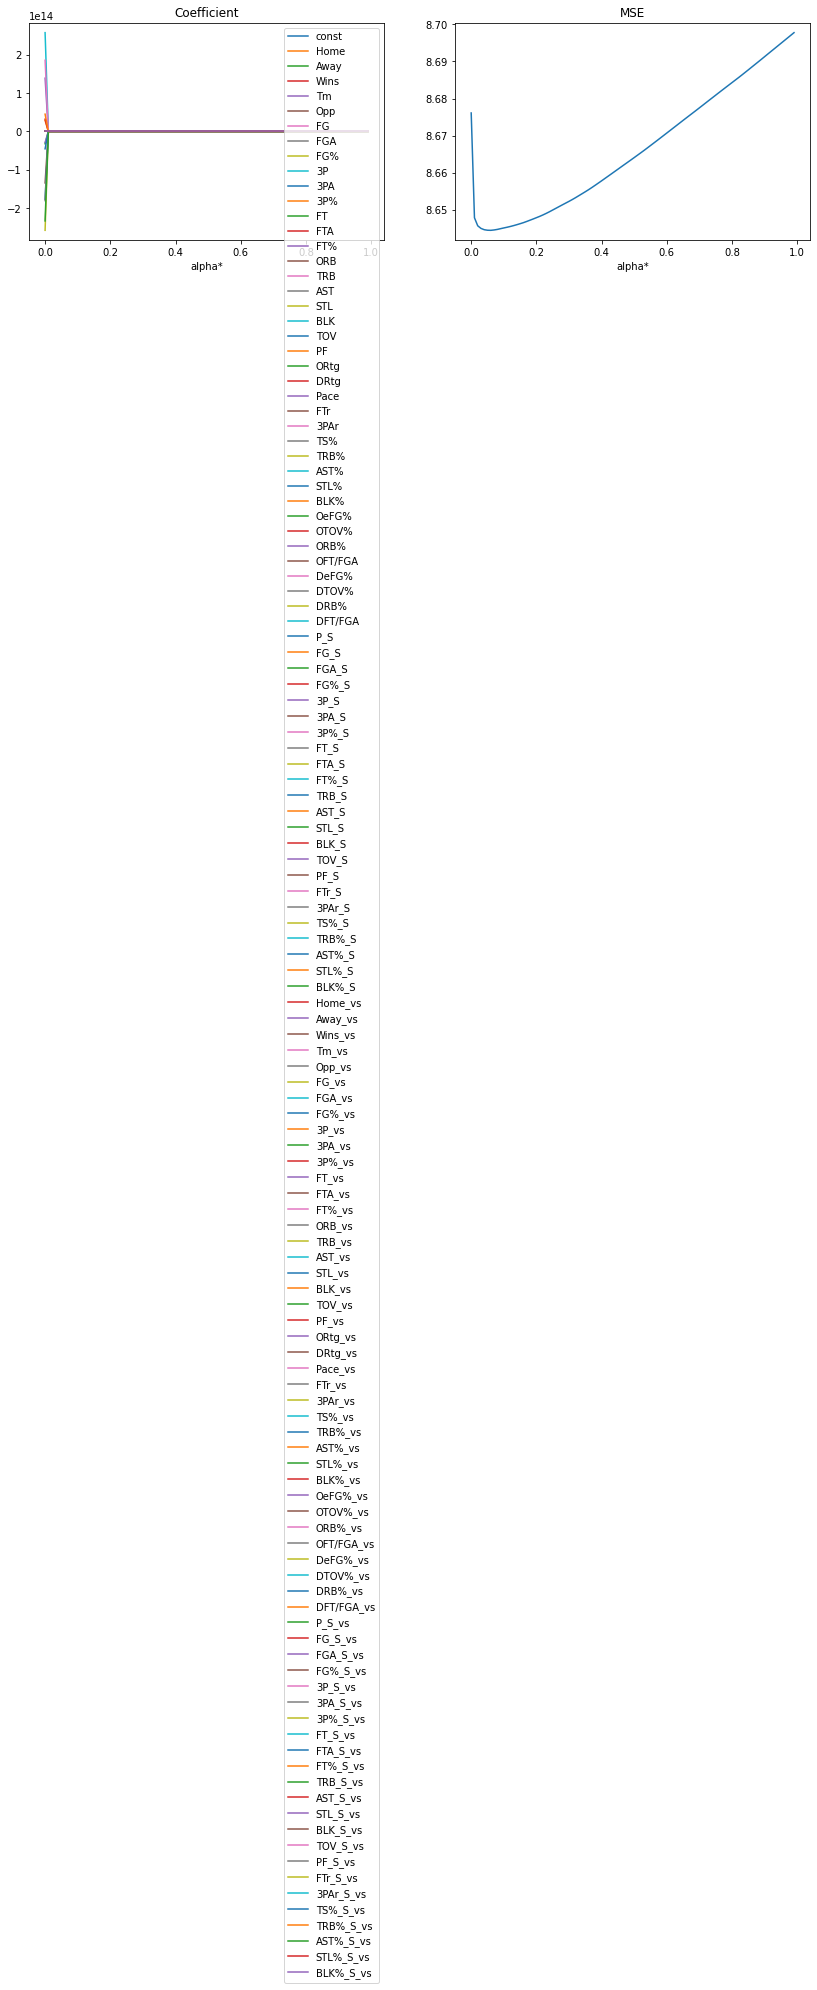

In [75]:

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0] = df.iloc[:100, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficient')

ax[1] = df.iloc[:100, -1].plot(ax=ax[1])
ax[1].set_title('MSE')

In [76]:
!say "hello"